In [132]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os,sys
import cv2
import time
import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tqdm import tqdm
from scipy import ndimage
from PIL import Image
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from IPython.display import Image as _Imgdis
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [1]:
#Directory variables
DATADIR = r"." # The directory to SAFE and UNSAFE PFM/PNG images
STATES_PNG = ["Safe_Collection", "Unsafe_Collection"] #Sub-directories for png files
SAFE_IMG_PNG = STATES_PNG[0] 
UNSAFE_IMG_PNG = STATES_PNG[1]

In [2]:
def buildDF():
    #dataToAR()

    #appends safe & unsafe images to the appropriate lists to later use as labels
    imageSafeList = pd.Series()
    imageUnsafeList = pd.Series()
    images_df = pd.DataFrame(columns=["image_Data", "State"])
    
    
    for file in os.listdir(DATADIR + '\\' + SAFE_IMG_PNG):
        try:
            
            frame = cv2.imread(DATADIR + '\\' + SAFE_IMG_PNG + '\\' + file)
            frame = cv2.resize(frame, (50, 50))
            images_df.loc[file] = [frame, "Safe"]
    
        except Exception as e:
            continue

    for file in os.listdir(DATADIR + '\\' + UNSAFE_IMG_PNG):
        try:
            frame = cv2.imread(DATADIR + '\\' + UNSAFE_IMG_PNG + '\\' + file)
            frame = cv2.resize(frame, (50, 50))
            images_df.loc[file] = [frame, "Unsafe"]

        except Exception as e:
            continue

    return images_df

In [3]:
'''def dataPrep(image_df): 
    folder_safe = DATADIR + '\\'+ STATES_PNG[0]
    folder_unsafe = DATADIR + '\\'+ STATES_PNG[1]
    
    safeFiles = [x for x in os.listdir(folder_safe) if os.path.isfile(os.path.join(folder_safe, x))]
    unsafeFiles = [y for y in os.listdir(folder_unsafe) if os.path.isfile(os.path.join(folder_unsafe, y))]

    print("Working with {0} images".format(len(safeFiles)))
    print("Image examples: ")
    
    print(type(safeFiles))
    
    for i in range(40, 42):
        print(safeFiles[i])
        display(_Imgdis(filename=folder_safe + "/" + safeFiles[i], width=240, height=320))
    
    train_data = []
    y_train = []
    for file in safeFiles:
        frame = cv2.imread(DATADIR + '\\' + STATES_PNG[0] + '\\' + file)
        im = Image.open(frame)
        print(im.size)
        train_data.append(file)
        y_train.append("safe")
        
        
    print("Files in train_data: %d" % len(train_data))
    
    channels = 3
    nb_classes = 1
    
    dataset = np.ndarray(shape=(len(train_data), channels, 50, 50), dtype=np.float32)
    
    i = 0
    for file in train_data:
        img = load_img(folder_safe+"/"+file)
        img.thumbnail((50, 50))
        #numpy array conversion
        x = img_to_array(img)
        x.reshape((3,120,160))
        #normalize
        x = (x - 128.0) / 128.0
        dataset[i] = x
        i += 1
        if i % 250 == 0:
            print("%d images to array" % i)
    print("All images to array!")
    splitData(y_train, x_data)
    '''

In [ ]:
def dataSplit(dataframe):
    
    

In [129]:
def CNN_training(input_df):
    #Splitting 
    X_train, X_test, y_train, y_test = train_test_split(dataset, y_train, test_size=0.2, random_state=33)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=33)
    print("Train set size: {0}, Val set size: {1}, Test set size: {2}".format(len(X_train), len(X_val), len(X_test)))
    pickle_out = open("X.pickle", "wb")
    pickle.dump(X,pickle_out)
    pickle_out.close()

    pickle_out = open("y.pickle", "wb")
    pickle.dump(y,pickle_out)
    pickle_out.close()

    pickle_in = open("X.pickle", "rb")
    X = pickle.load(pickle_in)

    pickle_in = open("y.pickle", "rb")
    y = pickle.load(pickle_in)

    X = X/255.0 #normalize
    X = np.array(X)
    
    dense_layers = [0]
    layer_sizes = [64]
    conv_layers = [1]

    for dense_layer in dense_layers:
        for layer_size in layer_sizes:
            for conv_layer in conv_layers:
                NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
                print(NAME)
                model = Sequential() #feed-forward network
                model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[:]))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

            model.compile(loss='binary_crossentropy',
                            optimizer='adam',
                            metrics=['accuracy'],
                            )

            model.fit(X, y,
                        batch_size=32,
                        epochs=10,
                        validation_split=0.1,
                        callbacks=[tensorboard])

    model.save('CNN_tester.model')

Working with 85 images
Image examples: 
<class 'list'>
46_0.png


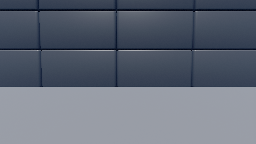

47_0.png


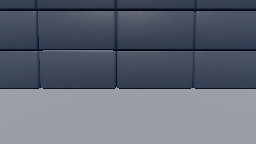

AttributeError: 'numpy.ndarray' object has no attribute 'read'

In [130]:
def main():
    #Here we are building a dataframe of our images and their labels
    images_df = buildDF()
    dataPrep(images_df)
main()